In [2]:
%matplotlib inline
import mne
import matplotlib.pyplot as plt

fname = "./oddball-epo.fif"
epochs = mne.read_epochs(fname)

mne.set_log_level(True)

event_ids = {"standard/stimulus": 200, "target/stimulus": 100}
#EEG Aktivierung basierend condition vorhersagen

Reading ./oddball-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
212 matching events found
Applying baseline correction (mode: mean)
212 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


## MVPA/decoding

Can we predict trial type from EEG activity?

In [3]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score #unabhängiges modell in dem wir konstruieren und validieren

In [4]:
epochs.pick_types(eeg=True)
X = epochs.get_data()  # features, woraus wir vorhersagen wollen
y = epochs.events[:, -1] == event_ids["target/stimulus"]  # targets, was wir vorhersagen wollen, 1 vs. 0 target vs. standard
X.shape, y.shape

((212, 63, 71), (212,))

In [ ]:
y[:9]

X has the wrong shape - `samples`, `channels`, `times`, should be `samples`, `features`.

We can use `mne.decoding.Vectorizer` to correctly shape the data. It fits right into a scikit-learn pipeline.

In [5]:
from mne.decoding import Vectorizer
clf = make_pipeline(Vectorizer(), StandardScaler(),
                    LinearSVC(class_weight="balanced")
                   )

The resulting object behaves exactly as any other scikit-learn classifier:

In [6]:
clf.fit(X, y)

Pipeline(memory=None,
     steps=[('vectorizer', <mne.decoding.transformer.Vectorizer object at 0x0000021D80B9A860>), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearsvc', LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [7]:
clf.predict(X[:9])

array([ True, False,  True, False,  True, False,  True, False, False])

Of course, usually we care about cross-validated scores.

In [8]:
cross_val_score(clf, X, y)  # accuracy, soll aber auch bezogen auf neue  daten funktionieren, bis jetzt die selben
#daten für fitting und validierung benutzt

array([0.76388889, 0.77142857, 0.72857143])

So there is some decodable information in the brain data. Can we investigate this in a bit more detail?
For example: at which time points in the trial is there information about trial category?

We need two more tools for this: one to train and score at each time point, and one to handle the cross-validated scoring for the former.

In [9]:
from mne.decoding import SlidingEstimator, cross_val_multiscore
sl = SlidingEstimator(clf)

In [10]:
scores_time_decoding = cross_val_multiscore(sl, X, y)

In [11]:
scores_time_decoding.shape

(3, 71)

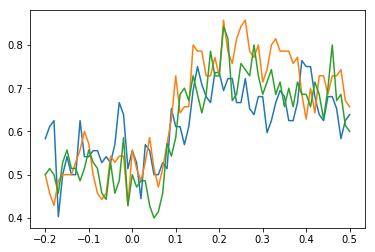

In [12]:
fig, ax = plt.subplots()
ax.plot(epochs.times, scores_time_decoding.T)
plt.show()

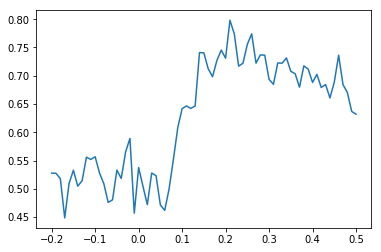

In [13]:
fig, ax = plt.subplots()
ax.plot(epochs.times, scores_time_decoding.mean(0))
plt.show()

But is the same thing happening at each time point? We can investigate that with generalization across time decoding.

In [14]:
from mne.decoding import GeneralizingEstimator
gen = GeneralizingEstimator(clf)
scores_gat = cross_val_multiscore(gen, X, y)
# Architektur der Prozesse kann unterschiedlich sein

In [15]:
scores_gat.shape #Y-Achse wann classifier trainiert wurde, X Achse wann er getestet wurde

(3, 71, 71)

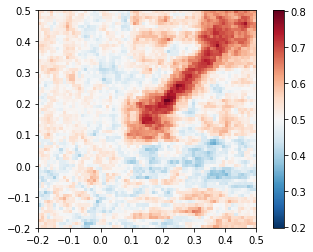

In [16]:
import numpy as np
data = scores_gat.mean(0)
vmax = np.abs(data).max()
tmin, tmax = epochs.times[[0, -1]]

fig, ax = plt.subplots()
im = ax.imshow(
    data,
    origin="lower", cmap="RdBu_r",
    extent=(tmin, tmax, tmin, tmax),
    vmax=vmax, vmin=1-vmax);

plt.colorbar(im)

We can easily attempt more complex decoding pipelines.

In [18]:
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA

In [19]:
pca = UnsupervisedSpatialFilter(PCA(.85))

In [20]:
pca_clf = make_pipeline(pca, Vectorizer(), StandardScaler(), LinearSVC())

In [21]:
cross_val_score(pca_clf, X, y)

array([0.69444444, 0.74285714, 0.67142857])

What do the learned patterns actually look like?

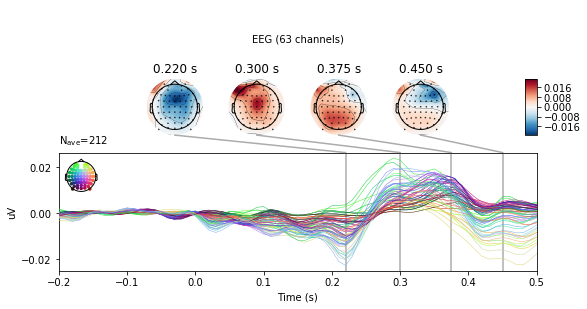

In [22]:
svc = LinearSVC(class_weight="balanced")
topos = np.array([svc.fit(time_point.T, y).coef_ * time_point.std(1)
                  for time_point in X.T])[:, 0, :]
topo_ev = mne.EvokedArray(topos.T, info=epochs.info, tmin=-.2, nave=len(y))
topo_ev.plot_joint(times=[.22, .3, .375, .45]);